In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,  GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train_df = pd.read_csv('../../../data/feature/cba_train.csv')
test_df = pd.read_csv('../../../data/feature/cba_test.csv')

In [77]:
X_tr, y_tr = train_df.iloc[:, :-1], train_df.iloc[:,-1]
X_test = test_df.copy()
X, X_val, y, y_val = train_test_split(X_tr, y_tr, random_state=443, test_size=0.2, shuffle=False)

In [4]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
SEED = 443 
NFOLDS = 5 
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [33]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    i=0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=1

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [6]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_val)
        if self.metric == 'acc':
            return accuracy_score(y_val, preds)
        else:
            return roc_auc_score(y_val, preds, average='macro')
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params

In [7]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
rf_params = optimizer.optimize()
rf_params['random_state'] = 666

[I 2021-03-26 22:44:13,480] A new study created in memory with name: no-name-b053da2a-8f93-4a96-b055-6fffc94fe2fb
[I 2021-03-26 22:44:14,807] Trial 0 finished with value: 0.2418906394810009 and parameters: {'max_depth': 6, 'n_estimators': 132, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:15,378] Trial 1 finished with value: 0.2418906394810009 and parameters: {'max_depth': 3, 'n_estimators': 93, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:15,542] Trial 2 finished with value: 0.2418906394810009 and parameters: {'max_depth': 6, 'n_estimators': 16, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:15,798] Trial 3 finished with value: 0.2418906394810009 and parameters: {'max_depth': 2, 'n_estimators': 48, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:16,828] Trial 4 finished with value: 0.2418906394810009 and p

In [8]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
et_params = optimizer.optimize()
et_params['random_state'] = 666

[I 2021-03-26 22:44:34,497] A new study created in memory with name: no-name-5b1d5a4b-1a68-4147-a228-eacaac042c47
[I 2021-03-26 22:44:35,113] Trial 0 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 132, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:35,717] Trial 1 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:35,810] Trial 2 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 16, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:36,003] Trial 3 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 48, 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:37,006] Trial 4 finished with value: 0.2418906394810009 and p

In [9]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
abc_params = optimizer.optimize()
abc_params['random_state'] = 666

[I 2021-03-26 22:44:48,916] A new study created in memory with name: no-name-060b0fb2-bd86-48a2-9382-284918a4ea52
[I 2021-03-26 22:44:50,909] Trial 0 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 132, 'learning_rate': 0.8442645495290093}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:51,966] Trial 1 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 64, 'learning_rate': 0.12941235380242858}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:53,446] Trial 2 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 93, 'learning_rate': 0.2447206803141601}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:54,371] Trial 3 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 62, 'learning_rate': 0.049288387403100035}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:44:54,626] Trial 4 finished with value: 0.2418906394810009 and parame

In [10]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    model = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
gbc_params = optimizer.optimize()
gbc_params['random_state'] = 666

[I 2021-03-26 22:45:36,467] A new study created in memory with name: no-name-d654dc15-a63c-4981-8f53-67290fb3398c
[I 2021-03-26 22:45:37,384] Trial 0 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 12, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 22:45:45,476] Trial 1 finished with value: 0.24338752112726972 and parameters: {'n_estimators': 71, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.24338752112726972.
[I 2021-03-26 22:45:55,248] Trial 2 finished with value: 0.2448517361049972 and parameters: {'n_estimators': 70, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.2448517361049972.
[I 2021-03-26 22:45:59,847] Trial 3 finished with value: 0.2418906394810009 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.2448517361049972.
[I 2021-03-26 22:46:07,066] Trial 4 finished with value: 0.24160191735281614 and

In [13]:
def create_model(trial):
    kernel = trial.suggest_categorical("kernel", ["rbf"])  
    #"linear", "poly", 
    #gamma = trial.suggest_loguniform("gamma", 1e-1, 1)
    c = trial.suggest_uniform("C", 1e-1, 1)
    model = SVC(
        kernel=kernel,
        #gamma=gamma,
        C=c,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
svc_params = optimizer.optimize()
svc_params['random_state'] = 666

[I 2021-03-26 23:12:16,186] A new study created in memory with name: no-name-b54bcc0d-815a-447e-abf5-0803d7a228d4
[I 2021-03-26 23:12:24,954] Trial 0 finished with value: 0.2418906394810009 and parameters: {'kernel': 'rbf', 'C': 0.7303934096720512}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 23:12:34,060] Trial 1 finished with value: 0.2418906394810009 and parameters: {'kernel': 'rbf', 'C': 0.8597679785653911}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 23:12:43,009] Trial 2 finished with value: 0.2418906394810009 and parameters: {'kernel': 'rbf', 'C': 0.7088629023438628}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 23:12:51,994] Trial 3 finished with value: 0.2418906394810009 and parameters: {'kernel': 'rbf', 'C': 0.7550722515232674}. Best is trial 0 with value: 0.2418906394810009.
[I 2021-03-26 23:13:01,033] Trial 4 finished with value: 0.2418906394810009 and parameters: {'kernel': 'rbf', 'C': 0.9563121617017054}. Best is trial 

In [14]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=abc_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gbc_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [31]:
y_train = y_tr.values
x_train = X_tr.values
x_test = X_test.iloc[:,1:].values

In [34]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)
print("Training is complete")

Training is complete


In [35]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.00325974 0.02660233 0.0089428  0.00800106 0.00837929 0.48989618
 0.0038852  0.0026647  0.0077575  0.00354949 0.00390987 0.03352691
 0.05827282 0.04915412 0.00813534 0.27087386 0.01318878]
[0.00181971 0.00418334 0.00623498 0.00256443 0.00153746 0.71265159
 0.00237418 0.00177812 0.01102895 0.00231812 0.00273279 0.00260058
 0.03178847 0.08182262 0.00300968 0.12565045 0.00590454]
[0.00757576 0.08333333 0.02272727 0.01515152 0.00757576 0.0530303
 0.00757576 0.00757576 0.00757576 0.         0.00757576 0.21212121
 0.09090909 0.06818182 0.01515152 0.37121212 0.02272727]
[0.00932084 0.09735504 0.02390762 0.02727488 0.0239695  0.18520987
 0.00908255 0.00601462 0.02107721 0.01241938 0.0121759  0.12699607
 0.08896038 0.05987165 0.02718528 0.22963039 0.03954881]


In [43]:
rf_features=[0.00325974, 0.02660233, 0.0089428,  0.00800106, 0.00837929, 0.48989618, 0.0038852, 0.0026647, 0.0077575, 0.00354949, 0.00390987, 0.03352691, 0.05827282, 0.04915412, 0.00813534, 0.27087386, 0.01318878]
et_features=[0.00181971, 0.00418334, 0.00623498, 0.00256443,0.00153746, 0.71265159, 0.00237418, 0.00177812, 0.01102895, 0.00231812, 0.00273279, 0.00260058, 0.03178847, 0.08182262, 0.00300968, 0.12565045, 0.00590454]
ada_features=[0.00757576, 0.08333333, 0.02272727, 0.01515152, 0.00757576, 0.0530303, 0.00757576, 0.00757576, 0.00757576, 0.0, 0.00757576, 0.21212121, 0.09090909, 0.06818182, 0.01515152, 0.37121212, 0.02272727]
gb_features=[0.00932084, 0.09735504, 0.02390762, 0.02727488, 0.0239695, 0.18520987, 0.00908255, 0.00601462, 0.02107721, 0.01241938, 0.0121759,  0.12699607, 0.08896038, 0.05987165, 0.02718528,0.22963039, 0.03954881]

In [58]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [59]:
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Gender,0.003260,0.001820,0.007576,0.009321
1,Age,0.026602,0.004183,0.083333,0.097355
2,Ethnicity,0.008943,0.006235,0.022727,0.023908
3,Educational_Level,0.008001,0.002564,0.015152,0.027275
4,Income,0.008379,0.001537,0.007576,0.023970


In [46]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

[Text(0, 0, 'Gender'),
 Text(1, 0, 'Age'),
 Text(2, 0, 'Ethnicity'),
 Text(3, 0, 'Educational_Level'),
 Text(4, 0, 'Income'),
 Text(5, 0, 'Meal_Type'),
 Text(6, 0, 'Visted_Previously'),
 Text(7, 0, 'Previous_Cancellations'),
 Text(8, 0, 'Deposit_type'),
 Text(9, 0, 'Required_Car_Parking'),
 Text(10, 0, 'Use_Promotion'),
 Text(11, 0, 'Room_Rate'),
 Text(12, 0, 'month_Expected_checkin'),
 Text(13, 0, 'dayofweek_Expected_checkin'),
 Text(14, 0, 'stay'),
 Text(15, 0, 'booking_to_checkin'),
 Text(16, 0, 'total_participants')]

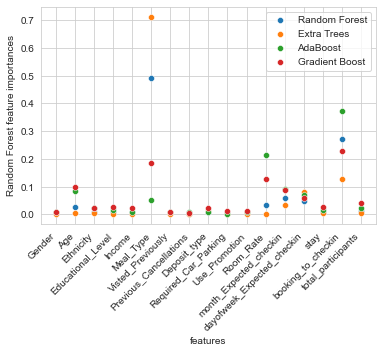

In [68]:
sns.set_style('whitegrid')
ax = sns.scatterplot(x='features',y='Random Forest feature importances',data=feature_dataframe,label='Random Forest')
ax = sns.scatterplot(x='features',y='Extra Trees feature importances',data=feature_dataframe,label='Extra Trees')
ax = sns.scatterplot(x='features',y='AdaBoost feature importances',data=feature_dataframe,label='AdaBoost')
ax = sns.scatterplot(x='features',y='Gradient Boost feature importances',data=feature_dataframe,label='Gradient Boost')
ax.set_xticklabels(
        feature_dataframe['features'],
        rotation=45,
        horizontalalignment='right'
    )


In [69]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Gender,0.003260,0.001820,0.007576,0.009321,0.005494
1,Age,0.026602,0.004183,0.083333,0.097355,0.052869
2,Ethnicity,0.008943,0.006235,0.022727,0.023908,0.015453


In [70]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [71]:
base_predictions_train = pd.DataFrame( 
    {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


In [72]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [83]:
x_sec_tr = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_sec_ts= np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)
X_sec, X_sec_val, y_sec, y_sec_val = train_test_split(x_sec_tr,y_tr,test_size=0.2, shuffle=True)

In [84]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_sec, y_sec)
y_pred = gbm.predict(X_sec_val)

[00:20:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:20:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [85]:
print(f"Accuracy: {accuracy_score(y_sec_val,y_pred)}")

Accuracy: 0.7790909090909091
